### Generare le istanze

Prima assicurati di avere tutti i pachetti necessari installati. Se non hai installato i pacchetti, esegui il comando seguente: 
```bash
pip3 install -r requirements.txt
```

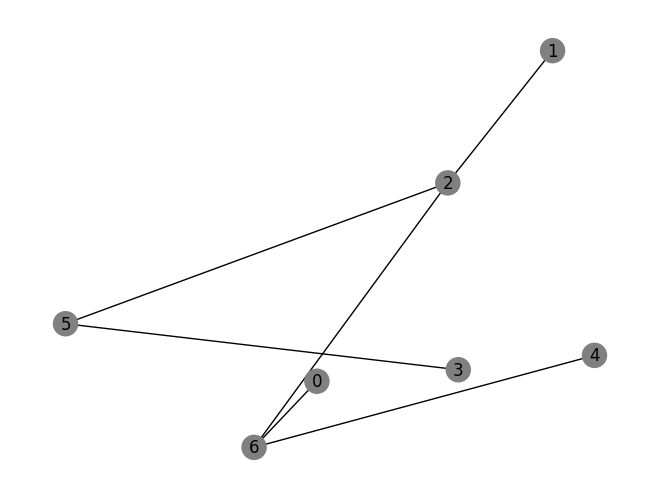

Number of edges:  6
Weight of the edges of the tree:  {(0, 6): 25.942243542145693, (1, 2): 50.15974481593781, (2, 5): 87.92041856133307, (2, 6): 99.16148445843275, (3, 5): 76.68767828015137, (4, 6): 72.44998274671983}
Number of nodes:  7
Number of flows:  3
Flows with their source and destination: [[0, 2], [4, 5], [5, 0]]


In [1]:
import networkx as nx
import utility_functions as uf

# CREATING A TREE NETWORK AND SAVING IT TO A .gml FILE

T = uf.generate_random_network_tree(7, 3, 150)
flows = uf.get_random_flows(T, 3)
uf.draw_tree(T)

nx.write_gml(T, "tree_net/tree.gml")

print("Number of edges: ", T.number_of_edges())
print("Weight of the edges of the tree: ", uf.get_weight_of_edges(T))
print("Number of nodes: ", T.number_of_nodes())
print("Number of flows: ", T.graph['K'])
print("Flows with their source and destination:", flows)

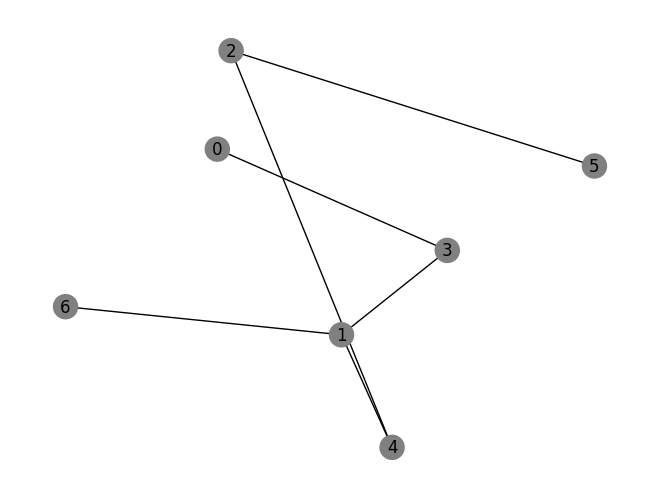

In [3]:
# READING THE TREE NETWORK FROM THE .gml FILE 

T = nx.read_gml("tree_net/tree.gml")
uf.draw_tree(T)

### Prima greedy naive

1. Iniziamo con un insieme vuoto di stazioni di ricarica.
2. Per ogni flusso da origine a destinazione, seguiamo il percorso dell'albero. Ogni veicolo (flusso) parte con autonomia L.
3. Mentre percorriamo il percorso, diminuiamo l'autonomia del veicolo della lunghezza dell'arco che si percorre.
4. Se l'autonommia non è sufficiente per percorrere il prossimo arco del percorso, quindi percorrendolo scenderebbe a zero o meno, posizioniamo una colonnina di ricarica sul nodo corrente.
5. Ripetiamo i passaggi 3-4 fino a quando tutti i veicoli hanno raggiunto le loro destinazioni.

Questa euristica cerca di minimizzare il numero di stazioni di ricarica posizionando ogni stazione il più lontano possibile lungo ogni percorso, dato che ogni veicolo parte con la carica completa e ogni stazione di ricarica ricarica completamente la batteria del veicolo.

charging_stations: {'2', '4'}
all paths:  [['4', '2'], ['6', '1', '4', '2'], ['5', '2', '4', '1', '3', '0']] 



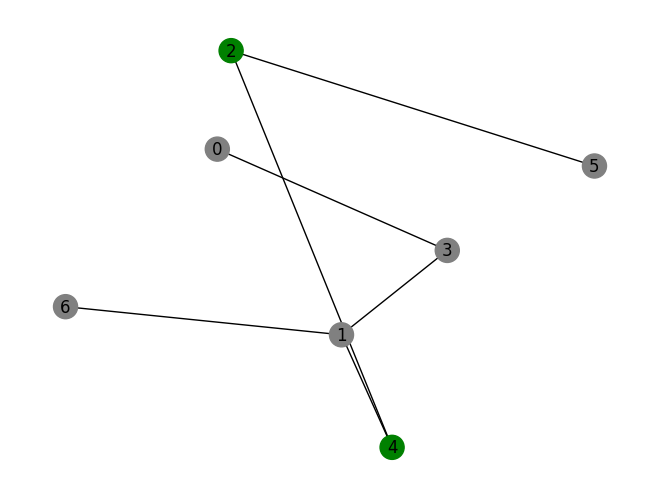

In [5]:
import networkx as nx
import utility_functions as uf

# READING THE TREE NETWORK FROM THE .gml FILE 
T = nx.read_gml("tree_net/tree.gml")

K = 3   # the number of flows
L = 150 # the battery capacity of the electric vehicle

flows = uf.get_random_flows(T, K)

def greedy_electric_charging(Tree: nx.Graph, flows: list, L: int):
    charging_stations = set()
    paths = uf.get_all_paths_of_all_flows(Tree, flows)
    for path in paths:
        charge = L
        for i in range(len(path) - 1):
            charge -= Tree.edges[(path[i], path[i+1])]['weight']
            if charge < 0:
                charging_stations.add(path[i])
                charge = L
    return charging_stations

charging_stations = greedy_electric_charging(T, flows, L)

print("Chargin stations on nodes:", charging_stations)
print("All the paths (a path for each flow): ", uf.get_all_paths_of_all_flows(T, flows), "\n")

uf.set_chrg_stations(T, charging_stations)
uf.draw_tree(T)

### Algoritmo costruttivo
1. Iniziamo con un insieme di stazioni di ricarica riempito randomicamente.
2. Per ogni flusso da origine a destinazione, seguiamo il percorso dell'albero. Ogni veicolo (flusso) parte con autonomia L.
3. Controlliamo se la soluzione creata inizialmente in maniera randomica è ammissibile, ossia se tutti i veicoli riescono a raggiungere la propria destinazione con le colonnine posizionate.
4. Se quanto detto al punto 3 è vero, allora si è trovata la soluzione.

Admissible charching stations: ['2', '3', '4', '6']


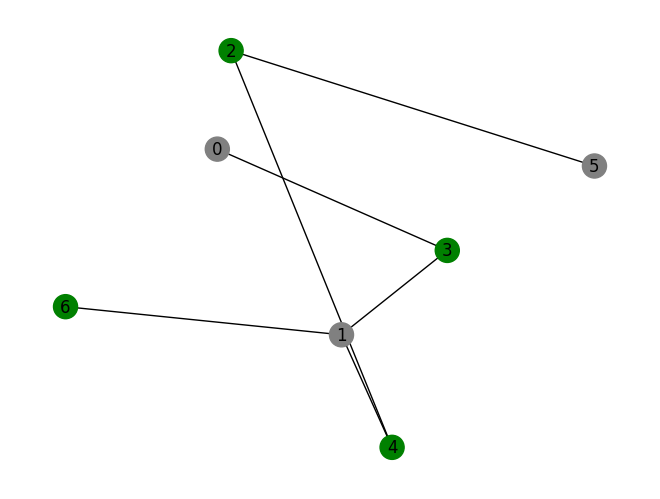

In [3]:
import networkx as nx
import utility_functions as uf

# READING THE TREE NETWORK FROM THE .gml FILE 
T = nx.read_gml("tree_net/tree.gml")

K = 3   # the number of flows
L = 150 # the battery capacity of the electric vehicle

flows = uf.get_random_flows(T, K)

while True:
    T = nx.read_gml("tree_net/tree.gml")
    charging_stations = uf.get_random_chrg_stations(T)
    if uf.is_admissible(T, flows, L):
        print("Admissible charching stations:", charging_stations)
        break
    else:
        pass

uf.draw_tree(T)